# **Neural Networks & Deep Learning**

> 欢迎同学们观看哔哩哔哩[《数之道》相关视频](https://www.bilibili.com/video/BV12b4y1X7Wv/?spm_id_from=333.788&vd_source=2dbf3ce169def83a8e8b53329f7d2135),提升自己对神经网络的理解。

在这个作业中，我们的任务是构建一个神经网络来识别手写数字图片，本质上是一个类别数为10的图像分类问题。首先我们会搭建一个简单的**神经网络**，然后分别实现**AdaGrad、RMSprop、Momentum、Nesterov Momentum和Adam**优化器来加速模型收敛。 
需要修改代码主要在第三部分：
- 搭建三层MLP网络模型
- **实现各种优化器**
- 训练模型


## 1 导入所需的Python库

In [1]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt
from utils import load_mnist

from collections import OrderedDict

## 2 加载数据并可视化

在这个实验中用到的数据集是MNIST。MNIST数据集是一个手写体数据集，包含训练集**60000**张图片和测试集**10000**张图片，其中每张图片是一张**28×28**的灰度图片，图片内容为一个**0-9**表示的手写数字。
一张灰度图片读取后是二维张量的，但是我们使用的神经网络中的全连接层的输入是一维张量。所以我们需要将一张二维灰度图片转换成一个一维张量（即向量），如图1：

<div align=center> 
<img src="./images/2d_to_1d.jpg" width="300" height="300" alt="2d_to_1d" >
<br>
图1. 展开二维图片成向量
</div>

在此之后每一个样本都是一个长度为**784**（28*28）的向量。 

手写数字识别任务是一个多分类任务，共包含有10类，分别用0-9表示，为了用一个向量表示一个类别，通常使用**one-hot**编码，比如在手写数字识别中，类别0和1对应的one-hot向量分别为： 
$$\mathrm{one-hot}(0)=\begin{bmatrix}1 \\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{bmatrix},\mathrm{one-hot}(1)=\begin{bmatrix}0 \\ 1\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ 0\\ \end{bmatrix}$$ 

<div align=center>
</div>




### 2.1 加载数据
在训练集中，我们需要把样本的标记$Y$转化为one-hot向量。

In [2]:
#加载训练集或测试集
path = './MNIST Data' #数据集文件所在目录
# 加载训练集合测试集
# 设置normalization为True，将数据缩放到[0,1]之间
# 设置one_hot_label为True，将标签转化为one_hot向量
(x_train, y_train), (x_test, y_test) = load_mnist(path, normalize=True, one_hot_label=True)

In [3]:
print('The shape of X_train is:',x_train.shape)
print('The shape of Y_train is:',y_train.shape)
print('The shape of X_test is:',x_test.shape)
print('The shape of Y_test is:',y_test.shape)

The shape of X_train is: (60000, 784)
The shape of Y_train is: (60000, 10)
The shape of X_test is: (10000, 784)
The shape of Y_test is: (10000, 10)


### 2.2 可视化数据集
下面在训练集中选取几个图片看一下。

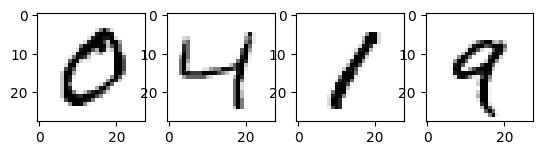

one hot 标签： [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
对应的实际标签： 0 4 1 9


In [4]:
fig = plt.figure()

ax1 = fig.add_subplot(141)
ax1.imshow(x_train[1,:].reshape(28, 28), cmap='Greys')
ax2 = fig.add_subplot(142)
ax2.imshow(x_train[2,:].reshape(28,28), cmap='Greys')
ax3 = fig.add_subplot(143)
ax3.imshow(x_train[3,:].reshape(28,28), cmap='Greys')
ax4 = fig.add_subplot(144)
ax4.imshow(x_train[4,:].reshape(28,28), cmap='Greys')
plt.show()
print('one hot 标签：',y_train[1,:],y_train[2,:],y_train[3,:],y_train[4,:])
print('对应的实际标签：',np.argmax(y_train[1,:]),np.argmax(y_train[2,:]),np.argmax(y_train[3,:]),np.argmax(y_train[4,:]))

## 3 全连接神经网络

接下来，搭建一个**三层全连接神经网络**。网络结构见图二：

<div align=center> 
<img src="./images/network_architecture.jpg" width="500" height="250" alt="network_architecture" align=center>
<br>
图2：三层全连接神经网络结构
</div>

对公式所用符号的说明：  
一般计算神经网络层数不算输入层，所以图2中为3层神经网络。用右上角的方括号表示相应的层，所有第1层的权重$W$为$W^{[1]}$，第1层的偏置项$b$为$b^{[1]}$(图中未标出)，第1层的激活值$A$为$A^{[1]}$。  

前两层的激活函数使用LeakyRelu，最后一层使用Softmax进行分类。

### 3.1 初始化网络参数

我们规定第1层的神经元个数为300，第二层个数为300，最后一层为10。输入向量$X$的维度为784，那么整个网络对应的参数也就可以确定了。  
$W^{[1]}$的shape为$(784,300)$，$b^{[1]}$的shape为$(300,)$  
$W^{[2]}$的shape为$(300,300)$，$b^{[2]}$的shape为$(300,)$  
$W^{[3]}$的shape为$(300,10)$，$b^{[3]}$的shape为$(10,)$  
这里**使用随机正态分布乘上比例因子0.01来初始化$W$， 把$b$都初始化为0**.  
**Hint**: 使用`np.random.randn()`,`np.zeros()`  


In [5]:
def initialize_parameters(input_size, hidden_size, output_size, weight_init_std):
    """
    @param input_size:输入向量维度
    @param hidden_size:中间神经元个数
    @param output_size:输出层神经元个数
    @param weight_init_sta:比例因子
    """
    np.random.seed(1)
    params = {}

    params['W1'] = np.random.randn(input_size,hidden_size) * weight_init_std
    params['b1'] = np.zeros((hidden_size,)) #请参考样例完成代码
    ### START CODE HERE ### 
    params['W2'] = np.random.randn(hidden_size,hidden_size)*weight_init_std
    params['b2'] = np.zeros((hidden_size,))
    params['W3'] = np.random.randn(hidden_size,output_size)*weight_init_std
    params['b3'] = np.zeros((output_size))
    
    ### END CODE HERE ### 

    print("W1's shape:",params['W1'].shape)
    print("b1's shape:",params['b1'].shape)
    print("W2's shape:",params['W2'].shape)
    print("b2's shape:",params['b2'].shape)
    print("W3's shape:",params['W3'].shape)
    print("b3's shape:",params['b3'].shape) #请在调用该函数的地方观察该神经网络各个参数的shape，是否符合预期
    
    return params

### 3.2 定义神经网络的每一层
我们将用单独的类来实现各种神经网络层：
- LeakyRelu
- Affine
- Softmax-with-loss

#### 3.2.1 LeakyRelu层

激活函数LeakyRelu的表达式为：
$$
\left\{\begin{matrix}
x & (x>0)\\ 
\alpha x & (x \leq 0)
\end{matrix}\right.
$$
可以通过上式求出$y$关于$x$的导数：
$$
\frac{\partial y}{\partial x} = \left\{\begin{matrix}
1 & (x>0)\\ 
\alpha & (x \leq 0)
\end{matrix}\right.
$$

如果正向传播时的输入$x$大于0，则反向传播会将下游的值原封不动地传给上游。反过来，如果正向传播时的$x$小于等于0，则反向传播中传给上游的信号将乘上一个很小的常数，保证neuron依然起作用。

<div align=center>
<img src="./images/LeakyReLu.png" width="350" height="250" alt="ReLU" align=center>
<br>
图3. LeakyRelu
</div>

In [6]:
class LeakyRelu:
    def __init__(self):
        self.mask = None 
        self.alpha = 0.1
        
    def forward(self, x):
        self.mask = (x <= 0) #mask表示选择出x的值中小于等于0的部分内容
        out = x.copy()
        ### START CODE HERE ###  #请参考LeakyRelu表达式实现前向传播过程
        out[self.mask] *=self.alpha 
        ### END CODE HERE ### 
        return out

    def backward(self, dout):
        ### START CODE HERE ###  #请参考LeakyRelu表达式y关于x的导数公式实现反向传播过程
        dout[self.mask] *= self.alpha
        ### END CODE HERE ### 
        dx = dout
        return dx

测试效果

In [7]:
leakyRelu = LeakyRelu()
x = np.array( [[1.0, -0.5], [-2.0, 3.0]] )
leakyRelu.forward(x), leakyRelu.backward(x)

(array([[ 1.  , -0.05],
        [-0.2 ,  3.  ]]),
 array([[ 1.  , -0.05],
        [-0.2 ,  3.  ]]))

#### 3.2.2 Affine层

神经网络的正向传播中，为了计算加权信号的总和，使用了矩阵的乘积运算，回顾一下公式：
$$
Y = XW + B
$$
即`Y = np.dot(X, W) + B`。假设X，W，B的shape分别为(2,)、(2,3)、(3,)如图4，现在将这里进行的求矩阵的乘积与偏置的和的运算用计算图表示出来。将乘积运算用“dot”节点表示的话，则np.dot(X, W) + B的运算如图5：
<div align=center>
<img src="./images/Affine1.png"><br>
图4. 单向量正向传播
</div>
<div align=center>
<img src="./images/Affine2.png"><br>
图5. Affine
</div>

以矩阵为对象的反向传播，按矩阵的各个元素进行计算时，步骤和以标量为对象的计算图相同。用公式表示：
$$
\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot W^T
$$
  
$$
\frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial Y}
$$
根据这个式子我们可以得到一个向量反向传播的计算图（见图6）。
<div align=center>
<img src="./images/Affine3.png"><br>
图6. 单向量反向传播
</div>


现在我们考虑N个数据一起进行正向传播（见图7），与刚刚不同的是，现在输入X的shape是(N, 2)。之后就和前面一样，在计算图上进行矩阵计算。反向传播时，需要注意矩阵的shape，推导出$\frac{\partial L}{\partial X}$ 和 $\frac{\partial L}{\partial W}$的过程与单个向量类似。

<div align=center>
<img src="./images/Affine4.png"><br>
图7. N个向量反向传播
</div>



In [8]:
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 权重和偏置参数的导数
        self.dW = None
        self.db = None

    def forward(self, x):
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x
        ### START CODE HERE ### 
        out = np.dot(x,self.W)+self.b
        ### END CODE HERE ### 
        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        ### START CODE HERE ### 
        self.dW = np.dot(self.x.T,dout)
        self.db = np.sum(dout)
        ### END CODE HERE ### 
        
        dx = dx.reshape(*self.original_x_shape)  # 还原输入数据的形状（对应张量）
        return dx

测试效果

In [9]:
w = np.ones([2, 3])
b = np.ones(3)
affine = Affine(w, b)
x = np.ones([1, 2])
# 假设 l = sum(y)
l = np.sum(affine.forward(x))
dout = np.ones([1,3])
l, affine.backward(dout)


(9.0, array([[3., 3.]]))

#### 3.2.3 Softmax-with-Loss层

softmax函数会将输入值正规化后输出，如图所示：
<div align=center>
<img src="./images/softmax.png">
<br>
图8. Softmax层
</div>

用$x_i$表示向量$x$的第$i$个分量。具体公式为
$$softmax(x_i)=\frac{e^{x_i}}{\sum_{j=1}^{C}{e^{x_j}}}$$ 


当最后一层为softmax时，使用的损失函数一般为交叉熵函数（$C$是类别的数量，在本次实验中即为10）：  
$$L(\hat{y},y)=-\sum_{j=1}^{C}{y_jlog\hat{y_j}}$$  
成本函数为（$m$是mini-batch的大小）：  
$$J(W^{[1]},b^{[1]},...)=\frac{1}{m}\sum_{i=1}^{m}{L(\hat{y}^{(i)},y^{(i)})}$$  
**mini-batch**：训练集共有60000个图片，我们不能把$(60000,784)$的张量直接放入神经网络计算。因此，每次正向传播从中选取m个图像来进行前向传播，所以输入的张量大小为$(m,784)$.

**Hint**：最后的Loss是个标量 

In [10]:
def softmax(x):
    x = x.T
    x = x - np.max(x, axis=0)
    y = np.exp(x) / np.sum(np.exp(x), axis=0)
    return y.T 

def cross_entropy_error(pred, y):
    if pred.ndim == 1:
        y = y.reshape(1, y.size)
        pred = pred.reshape(1, pred.size)
        
    # 监督数据是one-hot-vector的情况下，转换为正确解标签的索引
    if y.size == pred.size:
        y = y.argmax(axis=1)
             
    batch_size = pred.shape[0]
    
    res = None

    res = -np.sum(np.log(pred[:, y] + 1e-7)) / batch_size
    
    return res

实现Softmax 层（已完成）

考虑到这里也包含作为损失函数的交叉熵误差（cross entropy error），所以称为“Softmax-with-Loss 层”。Softmax-with-Loss 层（Softmax函数和交叉熵误差）的计算图如图9所示。

<div align=center>
<img src="./images/softmax-cross.png" align=center>
<br>
图9. Softmax-with-Loss 层
</div>
可以看到，Softmax-with-Loss 层有些复杂。这里只给出了最终结果。

In [11]:
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.pred = None # softmax的输出
        self.y = None # 监督数据

    def forward(self, x, y):
        self.y = y
        self.pred = softmax(x)
        self.loss = cross_entropy_error(self.pred, self.y)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.y.shape[0]
        if self.y.size == self.pred.size: # 监督数据是one-hot-vector的情况
            dx = (self.pred - self.y) / batch_size
        else:
            dx = self.pred.copy()
            dx[np.arange(batch_size), self.y] -= 1
            dx = dx / batch_size
        
        return dx

### 3.3 搭积木
现在我们把之前的每一层组合在一起就能搭成我们自己的三层神经网络了。
神经网络学习的步骤大致有5步：
1. 初始化权重
2. 随机选择一部分数据
3. 计算梯度
4. 更新参数
5. 重复步骤2,3,4


In [12]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        
        # 初始化权重
        self.params = initialize_parameters(input_size, hidden_size, output_size, weight_init_std)
        # 记录训练次数 adam里要用
        self.t = 0

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['LeakyRelu1'] = LeakyRelu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['LeakyRelu2'] = LeakyRelu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
    
        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        # 前向传播
        pred = x.copy()
        for layer in self.layers.values():
            # 通过forward函数完成前向传播
            ### START CODE HERE ###
            pred = layer.forward(x) #对每一层进行前向传播预测结果
            x = pred
            ### END CODE HERE ###
            
        return pred
        
    def loss(self, x, y):
        # 计算交叉熵损失
        ### START CODE HERE ### 
        pred = self.predict(x) #计算关于x的预测结果
        loss = self.lastLayer.forward(pred,y) #使用SoftmaxWithLoss层计算预测结果和y之间的交叉熵损失
        ### END CODE HERE ### 
        return loss
    
    def accuracy(self, x, y):
        # 输入数据x和标签y，输出当前神经网络的预测准确率
        accuracy = None
        pred = self.predict(x)
        pred = np.argmax(pred, axis=1)
        if y.ndim != 1:
            y = np.argmax(y, axis=1)
        
        accuracy = np.sum(pred == y) / float(x.shape[0])

        return accuracy
        
    def gradient(self, x, y):

        self.loss(x, y)

        # 反向传播
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            # print(layer)
            dout = layer.backward(dout)

        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        
        return grads

### 3.4 进行训练

#### 3.4.1 定义参数更新函数

In [13]:
def update_parameters(network, grads, learning_rate=0.001):
    """
    使用梯度下降法更新network的参数
    """

    #在这里我们给出了最基础的梯度下降法更新网络参数的实现代码，请同学们参考并完成其他优化算法的代码
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        # print(key)
        network.params[key] -= learning_rate * grads[key]  #在network现在的参数基础上减去学习率*梯度
    
    return 

#### 3.4.2 定义训练函数

In [14]:
def train_network(network, update_params_method, iters_num, train_size, batch_size, learning_rate):
    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)

    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = y_train[batch_mask]
        network.t += 1

        # 计算梯度
        grad = network.gradient(x_batch, t_batch)

        # 更新梯度
        update_params_method(network, grad, learning_rate)

        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, y_train)
            test_acc = network.accuracy(x_test, y_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
            print("Train acc:{:<.6f}\tTest acc:{:<.6f}".format(train_acc, test_acc))

In [15]:
# 读入数据
(x_train, y_train), (x_test, y_test) = load_mnist(path, normalize=True, one_hot_label=True)

In [16]:
# 定义神经网络
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [17]:
iters_num = 10000 #迭代次数
train_size = x_train.shape[0] #训练集的样本数量
batch_size = 100 #batch大小
learning_rate = 0.1 #学习率
train_network(network, update_parameters, iters_num, train_size, batch_size, learning_rate) #开始训练网络

Train acc:0.087500	Test acc:0.086200
Train acc:0.897267	Test acc:0.901800
Train acc:0.928883	Test acc:0.927000
Train acc:0.950750	Test acc:0.948400
Train acc:0.961783	Test acc:0.957000
Train acc:0.971233	Test acc:0.965700
Train acc:0.975550	Test acc:0.968100
Train acc:0.979517	Test acc:0.970800
Train acc:0.981550	Test acc:0.972300
Train acc:0.984417	Test acc:0.973500
Train acc:0.987367	Test acc:0.977900
Train acc:0.988967	Test acc:0.976800
Train acc:0.988100	Test acc:0.976000
Train acc:0.990667	Test acc:0.977200
Train acc:0.990433	Test acc:0.976100
Train acc:0.992433	Test acc:0.975700
Train acc:0.991883	Test acc:0.977300


### 3.5 梯度下降优化算法
下面回顾几种上课讲过的优化算法，注意它们之间的差异与联系。

#### 3.5.1AdaGrad  

当$J(\theta)$收敛到最低值附近时，因为步长$\alpha$大小固定的原因，$J(\theta)$会在最低值附近徘徊，而不能到达最低值。因此，AdaGrad的想法是随着迭代次数的增加降低学习率$\alpha$，学习率$\alpha$衰减的方式是
$$
\alpha^t = \frac{\alpha}{\sqrt{t+1}}
$$
其中t表示第t次迭代。

如果梯度数值小，$J(\theta)$的移动步长小，$J(\theta)$在坡度平缓的区域内下降速度会变慢。AdaGrad使用均方根来加快$J(\theta)$在平缓区域的下降速度。均方根的表示为
$$
\sigma^t = \sqrt{\frac{1}{t+1} \sum_{i=0}^{t}(g^i)2}
$$
其中$g^i$表示历史的梯度值。AdaGrad 的更新参数公式是
$$
\begin{aligned}
\theta^{t+1} & := \theta^t - \frac{\alpha^t}{\sigma^t} g^t \\
& := \theta^t - \frac{\alpha}{\sqrt{\sum_{i=0}^t (g^i)^2}} g^t
\end{aligned}
$$
在坡度平缓的区域，均方根的数值小，梯度除以一个数值小的数会变大，从而加大了$J(\theta)$移动步长，也因此加快梯度下降速度。但是，AdaGrad的缺点是，随着迭代次数的增大，均方根会越来越大，梯度趋近于0，导致训练提前停止。为了防止分母为0，我们给分母加上一个小数值$\epsilon =10^{-7}$。
$$
\theta^{t+1} := \theta^t - \frac{\alpha}{\sqrt{\sum_{i=0}^t (g^i)^2} + \epsilon} g^t
$$

我们可以看到分母里会计算所有历史梯度值的平方和，所以在实现的时候不用保存所有的历史梯度值，只需要保存一个纪录所有历史梯度平方和的值即可。每个参数的历史梯度和初始值为0。   
在代码实现中，我们使用`epsilon`代表ε  

In [18]:
def initialize_grads_squared(network):
    """
    初始化历史梯度和
    """
    grads_squared = {}
    
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        
        grads_squared[key] = np.zeros(network.params[key].shape)
        
    return grads_squared

In [19]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
grads_squared = initialize_grads_squared(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [20]:
def update_parameters_with_adagrad(network, grads, learning_rate=0.001, epsilon = 1e-7):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #计算历史梯度平方和
        grads_squared[key] += np.power(grads[key],2)
        network.params[key] -= (learning_rate*grads[key])/(np.sqrt(grads_squared[key])+epsilon)
        ### END CODE HERE ###
        
    return 

In [21]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_adagrad, iters_num, train_size, batch_size, learning_rate)

Train acc:0.305933	Test acc:0.303800
Train acc:0.868383	Test acc:0.870600
Train acc:0.885783	Test acc:0.887900
Train acc:0.894000	Test acc:0.895600
Train acc:0.898633	Test acc:0.899000
Train acc:0.902567	Test acc:0.902600
Train acc:0.905517	Test acc:0.905000
Train acc:0.908133	Test acc:0.908300
Train acc:0.909067	Test acc:0.910300
Train acc:0.912300	Test acc:0.911700
Train acc:0.914200	Test acc:0.913700
Train acc:0.916000	Test acc:0.915000
Train acc:0.916933	Test acc:0.916000
Train acc:0.918133	Test acc:0.916300
Train acc:0.919267	Test acc:0.917900
Train acc:0.920100	Test acc:0.919400
Train acc:0.920833	Test acc:0.920400


#### 3.5.2 RMSprop  
从AdaGrad算法的公式可看出，所有时刻的梯度都对当前的参数更新有影响。如果早先的梯度并不是一个正确的方向，那么这些糟糕的梯度还是会影响到当前的参数更新。因此，RMSprop相当于就是只记录当前时刻前的某一段历史梯度和而不是所有历史梯度和。  
RMSprop算法的公式如下：  
$$
 u^0 = 0 \\
 u^{t+1} = \rho u^t + (1-\rho) [\nabla J(\theta ^t)]^2 \\ 
 \theta^{t+1} = \theta^t - \frac{\alpha}{\sqrt{u^{t+1}}+\epsilon}\nabla J(\theta ^t) 
$$
这里$\rho$是超参数，一般设为0.999，也不会调它。$\epsilon$是防止分母为0。另外值得注意的是，因为要整合这几个算法在一起，而Adam算法又融合了各种算法，所以，关于优化算法的超参数的命名与Adam里保持一致，公式里的$\rho$用下面参数`beta`代替。这些算法几乎都要保存一些变量，它们的初始化基本与AdaGrad初始化的方法一致，所以这部分初始化的代码就不重复了。  

In [22]:
def update_parameters_with_rmsprop(network, grads, learning_rate=0.001, epsilon = 1e-7, beta=0.999):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #公式里的u就是这里的 grads_squared         
        grads_squared[key] = beta*grads_squared[key]+(1-beta)*np.power(grads[key],2)
        network.params[key] -= (learning_rate*grads[key])/(np.sqrt(grads_squared[key])+epsilon)
        
        ### END CODE HERE ###
    return 

In [23]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
grads_squared = initialize_grads_squared(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [25]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_rmsprop, iters_num, train_size, batch_size, learning_rate)

Train acc:0.987050	Test acc:0.970900
Train acc:0.997750	Test acc:0.980700
Train acc:0.998317	Test acc:0.981300
Train acc:0.995333	Test acc:0.977300
Train acc:0.997417	Test acc:0.979800
Train acc:0.994550	Test acc:0.976700
Train acc:0.995333	Test acc:0.978500
Train acc:0.997700	Test acc:0.979300
Train acc:0.998967	Test acc:0.980600
Train acc:0.997417	Test acc:0.977400
Train acc:0.998117	Test acc:0.979700
Train acc:0.998833	Test acc:0.980700
Train acc:0.998783	Test acc:0.980400
Train acc:0.998800	Test acc:0.980700
Train acc:0.996367	Test acc:0.977900
Train acc:0.998217	Test acc:0.981300
Train acc:0.999117	Test acc:0.981900


#### 3.5.3 Momentum
动量梯度下降（Gradient Descent with Momentum）基本思想就是计算梯度的指数加权平均数，并利用该指数加权平均数更新权重。具体过程为：
$$
v^0 = 0 \\
v^{t+1}  = \rho v^t +\alpha \nabla J(\theta ^t) \\
\theta^{t+1} = \theta ^t - v^{t+1}
$$

这里的$\rho$一般取0.9。 

In [26]:
def initialize_velocity(network):
    v = {}
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        v[key] = np.zeros((network.params[key]).shape) 
    return v

In [27]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v = initialize_velocity(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [28]:
def update_parameters_with_momentum(network, grads, learning_rate=0.001, beta=0.9):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
        
        #公式里的u就是这里的 grads_squared         
        v[key] = beta*v[key]+learning_rate*grads[key]
        network.params[key] -= v[key]
        
        ### END CODE HERE ###
    return 

In [29]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_momentum, iters_num, train_size, batch_size, learning_rate)

Train acc:0.085100	Test acc:0.083500
Train acc:0.439733	Test acc:0.446900
Train acc:0.320867	Test acc:0.320500
Train acc:0.679117	Test acc:0.684800
Train acc:0.777233	Test acc:0.783700
Train acc:0.836733	Test acc:0.838100
Train acc:0.864183	Test acc:0.865700
Train acc:0.878183	Test acc:0.878600
Train acc:0.886017	Test acc:0.887400
Train acc:0.893483	Test acc:0.893000
Train acc:0.898200	Test acc:0.898800
Train acc:0.902217	Test acc:0.903600
Train acc:0.905417	Test acc:0.906300
Train acc:0.907967	Test acc:0.908000
Train acc:0.911500	Test acc:0.912200
Train acc:0.914483	Test acc:0.914000
Train acc:0.916300	Test acc:0.915200


#### 3.5.4 Nesterov Momentum  
Nesterov Momentum算法与Momentum不同的是在于，它会提前计算一个在速度作用后的梯度。具体算法如下：
$$
v^{t+1} = \rho v^t + \alpha \nabla J(\theta ^t - \rho v^t) \\
\theta^{t+1} = \theta ^t - v^{t+1}
$$
但是在实现的时候，我们是不会算一次$J(\theta ^t)$再算一次$\nabla J(\theta ^t - \rho v^t)$的。具体编程实现时上式等价于下式：
$$
 v^{t+1} = \rho v^t + \alpha \nabla J(\theta ^t) \\
 \theta^{t+1} = \theta ^t - \rho v^{t+1} - \alpha \nabla J(\theta ^t)
$$
这里的$\rho$一般取0.9。  

In [30]:
def update_parameters_with_nesterov_momentum(network, grads, learning_rate=0.001, beta=0.9):
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
                
        v[key] = beta*v[key]+learning_rate*grads[key]
        network.params[key] -= (beta*v[key]+learning_rate*grads[key])
        
        ### END CODE HERE ###
    return 

In [31]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v = initialize_velocity(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [32]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_nesterov_momentum, iters_num, train_size, batch_size, learning_rate)

Train acc:0.085150	Test acc:0.083700
Train acc:0.437983	Test acc:0.445100
Train acc:0.321867	Test acc:0.321200
Train acc:0.681133	Test acc:0.686600
Train acc:0.777883	Test acc:0.785300
Train acc:0.836783	Test acc:0.839300
Train acc:0.864383	Test acc:0.865900
Train acc:0.878633	Test acc:0.879300
Train acc:0.886133	Test acc:0.887800
Train acc:0.893383	Test acc:0.893100
Train acc:0.898083	Test acc:0.898900
Train acc:0.902117	Test acc:0.903100
Train acc:0.905250	Test acc:0.906300
Train acc:0.907967	Test acc:0.907700
Train acc:0.911567	Test acc:0.911800
Train acc:0.914217	Test acc:0.913800
Train acc:0.916317	Test acc:0.914900


#### 3.5.5 Adam
Adam优化算法（Adaptive Moment Estimation）是将Momentum和RMSprop结合在一起的算法，具体过程如下
$$
u^0 = 0 \\
v^0 = 0 \\
u^{t+1}  = \rho_2 u^t +(1-\rho_2) [\nabla J(\theta ^t)]^2 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{u^{t+1}}+\epsilon}v^{t+1}
$$
从上式可以看到，在最开始更新时，$u^{t},v^{t}$都是很小的。所以需要对早期的更新进行一个bias correction。完整公式如下
$$
u^0 = 0 \\
v^0 = 0 \\
u^{t+1}  = \rho_2 u^t +(1-\rho_2) [\nabla J(\theta ^t)]^2 \\
u^{t+1}_{corrected} = \frac{u^{t+1}}{1-\rho_2^t} \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
v^{t+1}_{corrected} = \frac{v^{t+1}}{1-\rho_1^t} \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{u^{t+1}_{corrected}}+\epsilon}v^{t+1}_{corrected}
$$

其中，一般设$\rho_1=0.9,\rho_2=0.999$.$\epsilon$也是防止分母过小或等于0.  

In [33]:
def initialize_adam(network) :
    v = {}
    u = {}

    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        v[key] = np.zeros(np.shape(network.params[key]))
        u[key] = np.zeros(np.shape(network.params[key]))
            
    return v, u

In [34]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v, u = initialize_adam(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [35]:
def update_parameters_with_adam(network, grads, learning_rate=0.001, epsilon=1e-7, beta1=0.9, beta2=0.999):
    v_corrected = {}
    u_corrected = {} 
    t = network.t #当前迭代次数
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ### 
                
        v[key] = beta1*v[key]+(1-beta1)*grads[key]
        v_corrected[key] = v[key]/(1-np.power(beta1,network.t))
        
        u[key] = beta2*u[key]+(1-beta2)*np.power(grads[key],2)
        u_corrected[key] = u[key]/(1-np.power(beta2,network.t))
        
        network.params[key] -= (learning_rate*v_corrected[key])/(np.sqrt(u_corrected[key])+epsilon)
        
        ### END CODE HERE ###
    return 

In [36]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_adam, iters_num, train_size, batch_size, learning_rate)

Train acc:0.305933	Test acc:0.303800
Train acc:0.958500	Test acc:0.953100
Train acc:0.970083	Test acc:0.965800
Train acc:0.979383	Test acc:0.970100
Train acc:0.985017	Test acc:0.973700
Train acc:0.988350	Test acc:0.975300
Train acc:0.988383	Test acc:0.974200
Train acc:0.992500	Test acc:0.978200
Train acc:0.992250	Test acc:0.977700
Train acc:0.992400	Test acc:0.978000
Train acc:0.993750	Test acc:0.979200
Train acc:0.991567	Test acc:0.976900
Train acc:0.993167	Test acc:0.977900
Train acc:0.996050	Test acc:0.979100
Train acc:0.995133	Test acc:0.980000
Train acc:0.995300	Test acc:0.978700
Train acc:0.995800	Test acc:0.978300


#### 3.5.6 AdaBelief
Adam优化算法中，梯度更新的方向是 $\frac{v_{t+1}}{\sqrt{u_{t+1}}}$, 其中 $u_{t+1}$ 是 $[\nabla J(\theta ^t)]^2$ 的指数移动平均(exponential moving average,EMA)。

AdaBelief优化算法将梯度方向改为了 $\frac{v_{t+1}}{\sqrt{s_{t+1}}}$, 其中 $s_{t+1}$ 是 $[\nabla J(\theta ^t)-v_{t}]^2$ 的指数移动平均，AdaBelief的算法过程具体如下：
$$
s^0 = 0 \\
v^0 = 0 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
s^{t+1}  = \rho_2 s^t +(1-\rho_2) [\nabla J(\theta ^t)-v_{t+1}]^2 \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{s^{t+1}}+\epsilon}v^{t+1}
$$

与Adam优化算法同理，从上式可以看到，AdaBelief优化算法在最开始更新时，$s^{t},v^{t}$都是很小的。所以需要对早期的更新进行一个bias correction。完整公式如下
$$
s^0 = 0 \\
v^0 = 0 \\
v^{t+1}  = \rho_1 v^t + (1-\rho_1)\nabla J(\theta ^t) \\
v^{t+1}_{corrected} = \frac{v^{t+1}}{1-\rho_1^t} \\
s^{t+1}  = \rho_2 s^t +(1-\rho_2) [\nabla J(\theta ^t)-v_{t+1}]^2 \\
s^{t+1}_{corrected} = \frac{s^{t+1}}{1-\rho_2^t} \\
\theta^{t+1} = \theta ^t - \frac{\alpha}{\sqrt{s^{t+1}_{corrected}}+\epsilon}v^{t+1}_{corrected}
$$

其中，一般设$\rho_1=0.9,\rho_2=0.999$.$\epsilon$也是防止分母过小或等于0. 

In [37]:
def initialize_adambelief(network) :
    v = {}
    s = {}
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ###  #请初始化v和s
        v[key] = 0
        s[key] = 0
        ### END CODE HERE ###  
    return v, s

In [38]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v, s = initialize_adambelief(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [39]:
def update_parameters_with_adambelief(network, grads, learning_rate=0.001, epsilon=1e-7, beta1=0.9, beta2=0.999):
    v_corrected = {}
    s_corrected = {} 
    t = network.t #当前迭代次数
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ###                
        v[key] = beta1*v[key]+(1-beta1)*grads[key]
        v_corrected[key] =  v[key]/(1-np.power(beta1,network.t))
    
        s[key] = beta2*s[key]+(1-beta2)*np.power(grads[key]-v[key],2)
        s_corrected[key] = s[key]/(1-np.power(beta2,network.t))
        
        network.params[key] -= (learning_rate*v_corrected[key])/(np.sqrt(s_corrected[key])+epsilon)
        ### END CODE HERE ###
    return 

In [40]:
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.001
train_network(network, update_parameters_with_adambelief, iters_num, train_size, batch_size, learning_rate)

Train acc:0.313700	Test acc:0.311900
Train acc:0.960467	Test acc:0.955400
Train acc:0.970850	Test acc:0.965300
Train acc:0.981183	Test acc:0.970400
Train acc:0.985850	Test acc:0.974900
Train acc:0.988117	Test acc:0.974900
Train acc:0.989167	Test acc:0.974400
Train acc:0.992033	Test acc:0.978700
Train acc:0.994133	Test acc:0.978600
Train acc:0.993683	Test acc:0.977800
Train acc:0.992567	Test acc:0.976200
Train acc:0.990833	Test acc:0.976800
Train acc:0.996383	Test acc:0.980100
Train acc:0.996583	Test acc:0.979000
Train acc:0.996667	Test acc:0.979100
Train acc:0.997933	Test acc:0.980800
Train acc:0.995617	Test acc:0.976400


## 4 总结
本次实验完整搭建了一个三层的全连接网络，使用了各种梯度更新优化算法训练MNIST数据集。  
或许你可以试试通过调整网络参数和超参数再把准确度提高一点？（记得记录每次训练时的数据结果）

In [41]:
def initialize_adambelief(network) :
    v = {}
    s = {}
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ###  #请初始化v和s
        v[key] = 0
        s[key] = 0
        ### END CODE HERE ###  
    return v, s

In [42]:
network = TwoLayerNet(input_size=784, hidden_size=300, output_size=10)
v, s = initialize_adambelief(network)

W1's shape: (784, 300)
b1's shape: (300,)
W2's shape: (300, 300)
b2's shape: (300,)
W3's shape: (300, 10)
b3's shape: (10,)


In [43]:
def update_parameters_with_adambelief(network, grads, learning_rate=0.0005, epsilon=1e-7, beta1=0.9, beta2=0.999):
    v_corrected = {}
    s_corrected = {} 
    t = network.t #当前迭代次数
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        ### START CODE HERE ###                
        v[key] = beta1*v[key]+(1-beta1)*grads[key]
        v_corrected[key] =  v[key]/(1-np.power(beta1,network.t))
    
        s[key] = beta2*s[key]+(1-beta2)*np.power(grads[key]-v[key],2)
        s_corrected[key] = s[key]/(1-np.power(beta2,network.t))
        
        network.params[key] -= (learning_rate*v_corrected[key])/(np.sqrt(s_corrected[key])+epsilon)
        ### END CODE HERE ###
    return 

In [50]:
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.000001
train_network(network, update_parameters_with_adambelief, iters_num, train_size, batch_size, learning_rate)

Train acc:0.999100	Test acc:0.979200
Train acc:0.999050	Test acc:0.979000


In [56]:
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.000001
train_network(network, update_parameters_with_adambelief, iters_num, train_size, batch_size, learning_rate)

Train acc:0.999217	Test acc:0.979200
Train acc:0.999217	Test acc:0.979200


In [58]:
iters_num = 1000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.0000001
train_network(network, update_parameters_with_adambelief, iters_num, train_size, batch_size, learning_rate)

Train acc:0.999267	Test acc:0.979100
Train acc:0.999267	Test acc:0.979200


In [60]:
iters_num = 500
train_size = x_train.shape[0]
batch_size = 50
learning_rate = 0.0000001
train_network(network, update_parameters_with_adambelief, iters_num, train_size, batch_size, learning_rate)

Train acc:0.999283	Test acc:0.979100


In [64]:
iters_num = 200
train_size = x_train.shape[0]
batch_size = 20
learning_rate = 0.0000001
train_network(network, update_parameters_with_adambelief, iters_num, train_size, batch_size, learning_rate)

Train acc:0.999267	Test acc:0.979200


最后最高的$Train$ $acc$为0.999283，$Test$ $ass$为0.9792.